In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy 
import boto3
import warnings

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance; 
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

client = boto3.client('s3')
path = "s3://misc.funpy/"
warnings.filterwarnings("ignore")


In [39]:
def optimize(students, employers):
    df = pd.read_csv(students)
    df['Problem Solving'] = df['Rank each skill on the list first to last. [Problem Solving]'].astype(str).str[0]
    df['Creativity'] = df['Rank each skill on the list first to last. [Creativity]'].astype(str).str[0]
    df['Research'] = df['Rank each skill on the list first to last. [Research]'].astype(str).str[0]
    df['Time Management'] = df['Rank each skill on the list first to last. [Time Management]'].astype(str).str[0]
    df['Communication'] = df['Rank each skill on the list first to last. [Communication]'].astype(str).str[0]
    # df['Critical Thinking'] = df[' [Critical Thinking]'].astype(str).str[0]

    newdf = df[['Problem Solving', 'Creativity', 'Research', 'Time Management', 'Communication']]
    newdf['Problem Solving'].replace("n", value="0", inplace=True)
    newdf['Creativity'].replace("n", value="0", inplace=True) 
    newdf['Research'].replace("n", value="0", inplace=True) 
    newdf['Time Management'].replace("n", value="0", inplace=True) 
    newdf['Communication'].replace("n", value="0", inplace=True) 
    # print(newdf)


    scaler = MinMaxScaler()
    new_df = pd.DataFrame(scaler.fit_transform(newdf), columns=newdf.columns[:], index=newdf.index)

    # print(new_df)
    # Setting the amount of clusters to test out
    cluster_cnt = [i for i in range(2, 12, 1)]

    # Establishing empty lists to store the scores for the evaluation metrics
    s_scores = []

    db_scores = []

    # Looping through different iterations for the number of clusters
    for i in cluster_cnt:
        
        # Hierarchical Agglomerative Clustering with different number of clusters
        hac = AgglomerativeClustering(n_clusters=i)
        
        hac.fit(new_df)
        
        cluster_assignments = hac.labels_
        
        ## KMeans Clustering with different number of clusters
        k_means = KMeans(n_clusters=i)
        
        k_means.fit(new_df)
        
        cluster_assignments = k_means.predict(new_df)
        
        # Appending the scores to the empty lists    
        s_scores.append(silhouette_score(new_df, cluster_assignments))
        
        db_scores.append(davies_bouldin_score(new_df, cluster_assignments))
    return [s_scores, db_scores]

In [45]:
def plot_evaluation(y, x=[i for i in range(2, 12, 1)]):
    """
    Plots the scores of a set evaluation metric. Prints out the max and min values of the evaluation scores.
    """
    
    # Creating a DataFrame for returning the max and min scores for each cluster
    df = pd.DataFrame(columns=['Cluster Score'], index=[i for i in range(2, len(y)+2)])
    df['Cluster Score'] = y
    
    # print('Max Value: Cluster #', df[df['Cluster Score']==df['Cluster Score'].max()])
    # print('\nMin Value: Cluster #', df[df['Cluster Score']==df['Cluster Score'].min()])
    # print('\n')
    
    # Plotting out the scores based on cluster count
    plt.figure(figsize=(16,6))
    plt.style.use('ggplot')
    plt.plot(x,y)
    plt.xlabel('# of Clusters')
    plt.ylabel('Score')
    plt.show()
    return df['Cluster Score']==df['Cluster Score'].max()

In [46]:
def cluster(csv, num_clusters, etc=None):
    df = pd.read_csv(csv)
    # print(df['Rank each skill on the list first to last. [Problem Solving]'])
    df['Problem Solving'] = df['Rank each skill on the list first to last. [Problem Solving]'].astype(str).str[0]
    df['Creativity'] = df['Rank each skill on the list first to last. [Creativity]'].astype(str).str[0]
    df['Research'] = df['Rank each skill on the list first to last. [Research]'].astype(str).str[0]
    df['Time Management'] = df['Rank each skill on the list first to last. [Time Management]'].astype(str).str[0]
    df['Communication'] = df['Rank each skill on the list first to last. [Communication]'].astype(str).str[0]
    # df['Critical Thinking'] = df[' [Critical Thinking]'].astype(str).str[0]

    newdf = df[['Problem Solving', 'Creativity', 'Research', 'Time Management', 'Communication']]
    newdf['Problem Solving'].replace("n", value="0", inplace=True)
    newdf['Creativity'].replace("n", value="0", inplace=True) 
    newdf['Research'].replace("n", value="0", inplace=True) 
    newdf['Time Management'].replace("n", value="0", inplace=True) 
    newdf['Communication'].replace("n", value="0", inplace=True) 
    # print(newdf)


    scaler = MinMaxScaler()
    # print(df)
    new_df = pd.DataFrame(scaler.fit_transform(newdf), columns=newdf.columns[:], index=newdf.index)

    # print(new_df)

    clustering = AgglomerativeClustering(num_clusters)

    # Fitting
    clustering.fit(new_df)

    # Getting cluster assignments
    cluster_assignments = clustering.labels_

    # Unscaling the categories then replacing the scaled values
    if 'Best email to reach you' in df.columns:
        df = df[['Best email to reach you']].join(pd.DataFrame(scaler.inverse_transform(newdf), columns=newdf.columns[:], index=newdf.index))
    else:
        df = df[['Company Name']].join(pd.DataFrame(scaler.inverse_transform(newdf), columns=newdf.columns[:], index=newdf.index))
    # Assigning the clusters to each profile
    df['Cluster #'] = cluster_assignments

    # Viewing the dating profiles with cluster assignments
    # print(df)
    return df


In [47]:
def match(students, employers, num_clusters):
    from clustering import cluster; import pandas as pd; import numpy as np; import scipy; from scipy.spatial import distance; from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

    clusteredEmployers = cluster(employers, num_clusters)

    clusteredStudents = cluster(students, num_clusters)

    for index, employer in clusteredEmployers.iterrows():
        cluster = employer['Cluster #']
        filtered_students = clusteredStudents[clusteredStudents['Cluster #'] == cluster]
        best_student = ""
        most_similar = -1
        for index, student in filtered_students.iterrows():
            arr = employer.values.tolist()
            student_arr = student.values.tolist()
            employer_values = np.array(arr[1:])
            student_values = np.array(student_arr[1:])
            cosine = cosine_similarity(employer_values.reshape(1, -1), student_values.reshape(1, -1))[0][0]
            if cosine > most_similar:
                most_similar = cosine
                best_student = student_arr[0]
        print("The best student for " + employer['Company Name'] + " is " + best_student + ". This student has a " + str(round(most_similar * 100, 1)) + "% similarity to the company's preferences.")

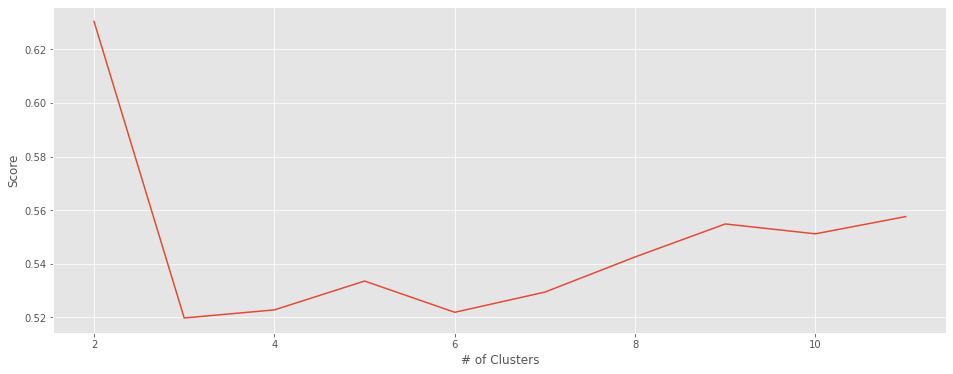

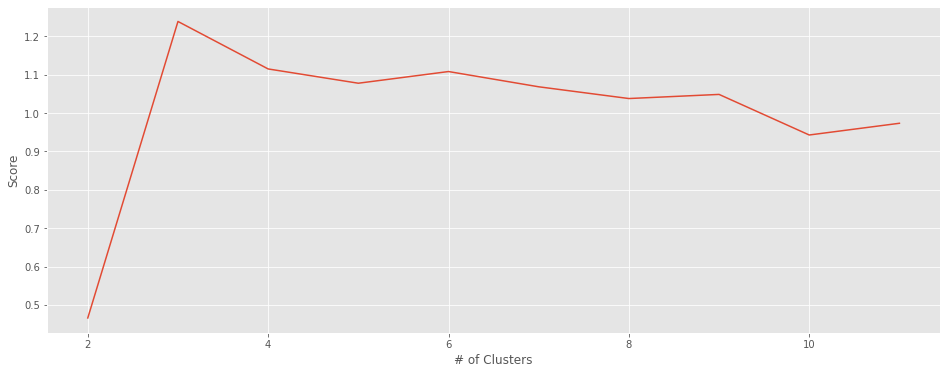


 

Silhoutte Score Optimal Clusters:  2
Silhouette Score Optimization: 
The best student for Cat 5 studios is aprisantiritonga@gmail.com. This student has a 97.8% similarity to the company's preferences.
The best student for Orlando World Live is abamant2@gmail.com . This student has a 2.3% similarity to the company's preferences.
The best student for Pivot Business Consulting is mitchellmansell98@gmail.com. This student has a 98.9% similarity to the company's preferences.
The best student for Fit Me In Now is abamant2@gmail.com . This student has a 2.4% similarity to the company's preferences.
The best student for Landen Conner Photo is abamant2@gmail.com . This student has a 2.4% similarity to the company's preferences.
The best student for Fit Me In Now is teresamamamo256@gmail.com. This student has a 99.4% similarity to the company's preferences.
The best student for Corgi Art House is lindseybowman@knights.ucf.edu. This student has a 99.1% similarity to the company's preferences.

In [48]:
students = path + "Student_Registration.csv"
employers = path + "CORRECT_Employer_Full_Registration.csv"
s_scores = optimize(students, employers)[0]
db_scores = optimize(students, employers)[1]
s_score_num_clusters = plot_evaluation(s_scores)
for i in range(2, len(s_score_num_clusters)):
    if s_score_num_clusters[i]:
        s_score_num_clusters = i
        break
db_score_num_clusters = plot_evaluation(db_scores)
for i in range(2, len(db_score_num_clusters)):
    if db_score_num_clusters[i]:
        db_score_num_clusters = i
        break
print("\n \n")

print("Silhoutte Score Optimal Clusters: ", s_score_num_clusters)

print("Silhouette Score Optimization: ")
match(students, employers, s_score_num_clusters)
print("\n \n")

print("Davies-Bouldin Score Optimal Clusters: ", db_score_num_clusters)
print("Davies-Bouldin Score Optimization: ")
match(students, employers, db_score_num_clusters)
